In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import jax
import jax.numpy as jnp
import numpy as np

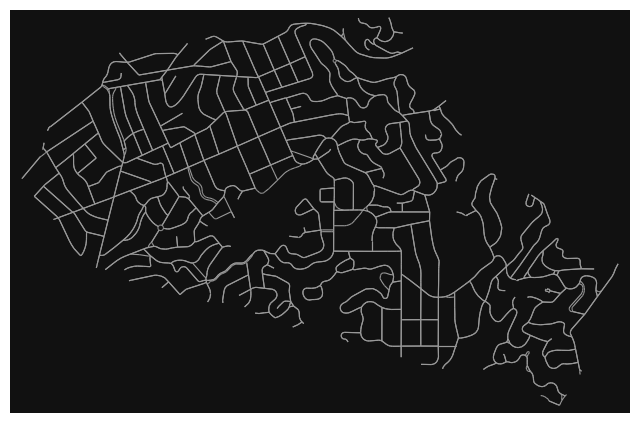

In [2]:
place_name = "Piedmont, California, USA"
G = ox.graph_from_place(place_name, network_type='drive', simplify=False)
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.8)

In [3]:
V_0 = 50 # Desired speed (km/h)
T = 1.2/3600 # Time gap (h)
rho_max = 120 # Maximum density (veh/km)

l_eff = 1/rho_max # Inverse of the minimum distance headway
rho_C = 1/(V_0*T + l_eff) # Critical value between free traffic and congested traffic
C = 1/(T + l_eff/V_0)

@jax.jit
def Q_e(rho):
    return jnp.maximum(0, jnp.where(rho<=rho_C, V_0*rho, (1-rho*l_eff)/T))

In [4]:
T_sim = 6
N_t = 300
dt = T_sim/N_t

place_name = "Piedmont, California, USA"
G = ox.graph_from_place(place_name, network_type='drive', simplify=False)

node_to_id = {val: i for i, val in enumerate(list(G.nodes()))}
node_list = list(G.nodes())

In [5]:
def init_graph():        
    I = np.zeros((len(node_list), len(node_list)))
    A = np.zeros_like(I)
    L = np.zeros_like(I)
    rho = np.zeros_like(I)

    for e_i,e_j, id in G.edges:
        i,j = node_to_id[e_i], node_to_id[e_j]
        rho[i,j]=rho_max/4
        A[i,j]=1.
        I[i,j]=1. # set depending highway type (osm)
        L[i,j]=G.edges[e_i, e_j, id]['length']

    return jnp.array(rho), jnp.array(A), jnp.array(I), jnp.array(L)

In [6]:
def plot_graph(rho, ax, title=''):
    weights = [rho[node_to_id[u],node_to_id[v]] for u,v in G.edges()]
    # Normalize the weights for colormap
    norm = plt.Normalize(min(weights), vmax=max(weights))
    #ax.set_title(title)
    cmap = plt.cm.viridis
    norm = Normalize(vmin=np.min(weights), vmax=np.max(weights))
    #nx.draw_networkx_edges(G, pos, node_size=0, arrowstyle='-', width=5, edge_color=weights, edge_cmap=cmap, ax=ax, edge_vmin=20, edge_vmax=40) #, edge_vmin = min(weights), edge_vmax=max(weights))
    fig, ax = ox.plot_graph(G, edge_color=cmap(norm(weights)), node_size=0, edge_linewidth=0.8, bgcolor = 'white', show=False, ax=ax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb = fig.colorbar(sm, ax=ax, orientation='vertical')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


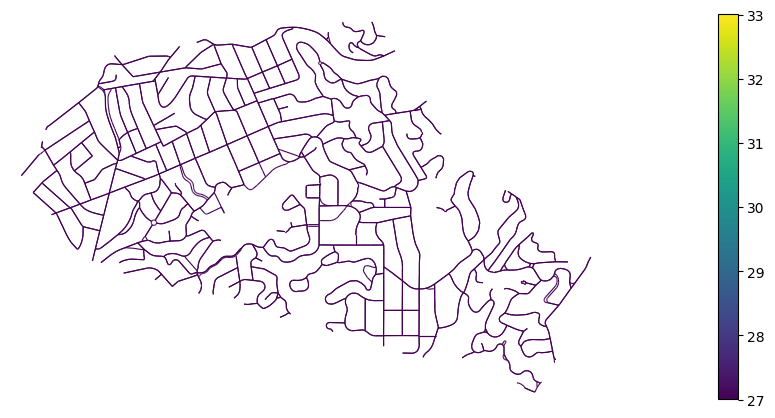

In [7]:
fig, ax = plt.subplots(figsize=(30,5))
rho, A, I, L = init_graph()
plot_graph(rho, ax)

In [8]:
@jax.jit
def CTM_step(rho, A, I, L, verbose=False):
    n = A.shape[0]
    flux = jnp.where(jnp.isclose(I, 0), 0, I*Q_e(rho/I))
    f_0 = jnp.sum(flux, axis=0)
    f_1 = jnp.sum(flux, axis=1)
    mask = jnp.logical_not(jnp.isclose(jnp.outer(jnp.sum(A, axis=0), jnp.sum(A, axis=1))*A,0))
    u = jnp.outer(f_0, jnp.ones(n))*mask
    w = jnp.outer(jnp.ones(n), f_1)*mask
    v = flux*mask

    rho_0 = jnp.sum(rho, axis=0)
    rho_1 = jnp.sum(rho, axis=1)
    u_local = jnp.outer(rho_0, jnp.ones(n))
    w_local = jnp.outer(jnp.ones(n), rho_1)
    v_local = rho

    d_inv = jnp.pow(jnp.sum(A, axis=1), -1)
    D_inv = jnp.diag(jnp.where(jnp.isinf(d_inv), 0, d_inv))
    u = jnp.dot(D_inv, u)
    u_local = jnp.dot(D_inv, u_local)

    mi1 = jnp.minimum(u, v)
    ma1 = jnp.maximum(u, v)
    Q_up = jnp.where(u_local<=v_local, mi1, ma1)

    mi2 = jnp.minimum(v, w)
    ma2 = jnp.maximum(v, w)
    Q_down = jnp.where(v_local<=w_local, mi2, ma2)

    l_inv = jnp.pow(L, -1)
    L_inv = jnp.where(jnp.isinf(l_inv), 0, l_inv)
    rho = rho - dt*L_inv*(Q_down - Q_up)
    return jnp.clip(rho, 0, rho_max)

In [9]:
rho, A, I, L = init_graph()


In [10]:
%%timeit
rho2 = CTM_step(rho, A, I, L)

291 ms ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


[]

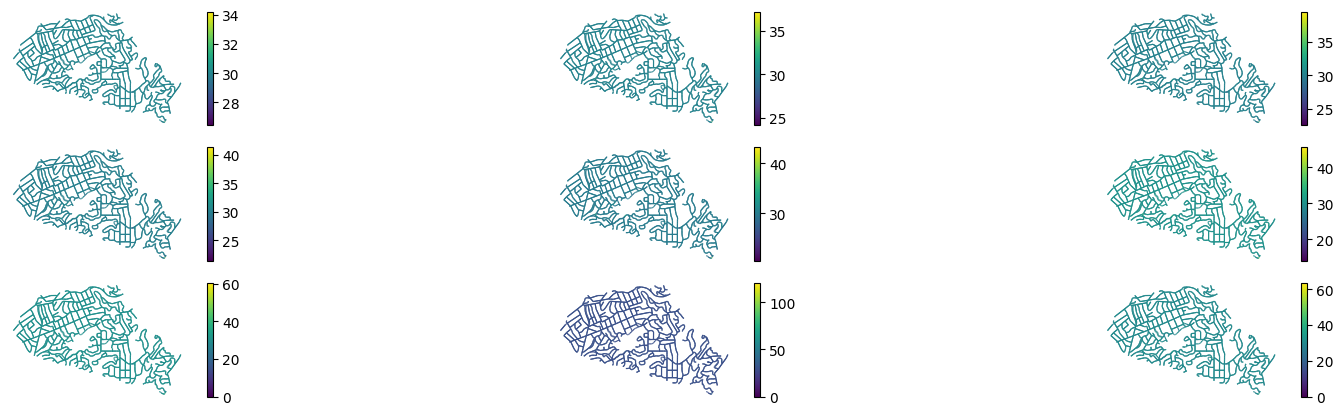

In [11]:
rho, A, I, L = init_graph()

G_checkpoints = []
for t_i in range(10):
    rho = CTM_step(rho, A, I, L)
    if t_i%1 == 0:
        G_checkpoints += [rho]

f, axs = plt.subplots(3, len(G_checkpoints)//3, figsize=(20,5))
for i, ax in enumerate(axs.reshape(-1)):
    plot_graph(G_checkpoints[i], ax=ax, title=f'Step {i*200}')

plt.plot()

In [12]:
rho, A, I, L = init_graph()

G_checkpoints = []
for t_i in range(N_t+1):
    rho = CTM_step(rho, A, I, L)
    if t_i%10 == 0:
        G_checkpoints += [rho]

[]

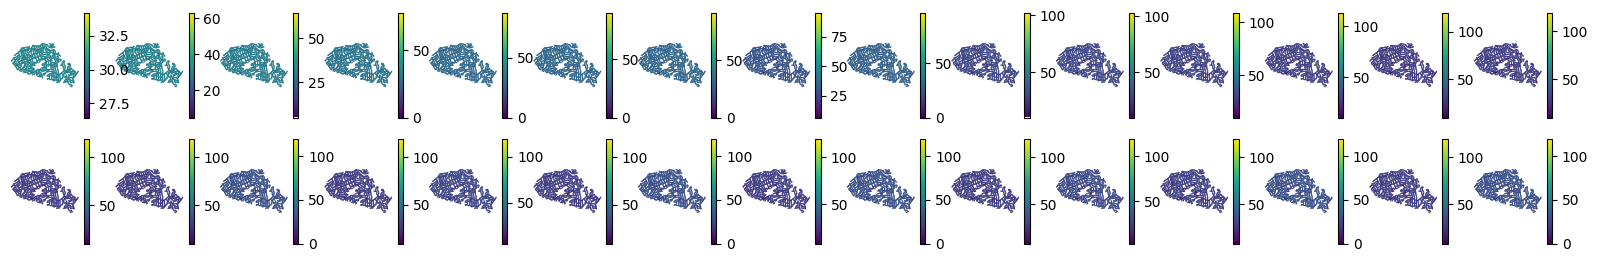

In [13]:
f, axs = plt.subplots(2, len(G_checkpoints)//2, figsize=(20,3))
for i, ax in enumerate(axs.reshape(-1)):
    plot_graph(G_checkpoints[i], ax=ax, title=f'Step {i*200}')

plt.plot()

In [14]:
def plot_graph2(rho, ax, title=''):
    weights = [rho[node_to_id[u],node_to_id[v]] for u,v in G.edges()]
    # Normalize the weights for colormap
    norm = plt.Normalize(min(weights), vmax=max(weights))
    #ax.set_title(title)
    cmap = plt.cm.viridis
    norm = Normalize(vmin=np.min(weights), vmax=np.max(weights))
    #nx.draw_networkx_edges(G, pos, node_size=0, arrowstyle='-', width=5, edge_color=weights, edge_cmap=cmap, ax=ax, edge_vmin=20, edge_vmax=40) #, edge_vmin = min(weights), edge_vmax=max(weights))
    fig, ax = ox.plot_graph(G, edge_color=cmap(norm(weights)), node_size=0, edge_linewidth=4, bgcolor = 'white', show=False, ax=ax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb = fig.colorbar(sm, ax=ax, orientation='vertical')

[]

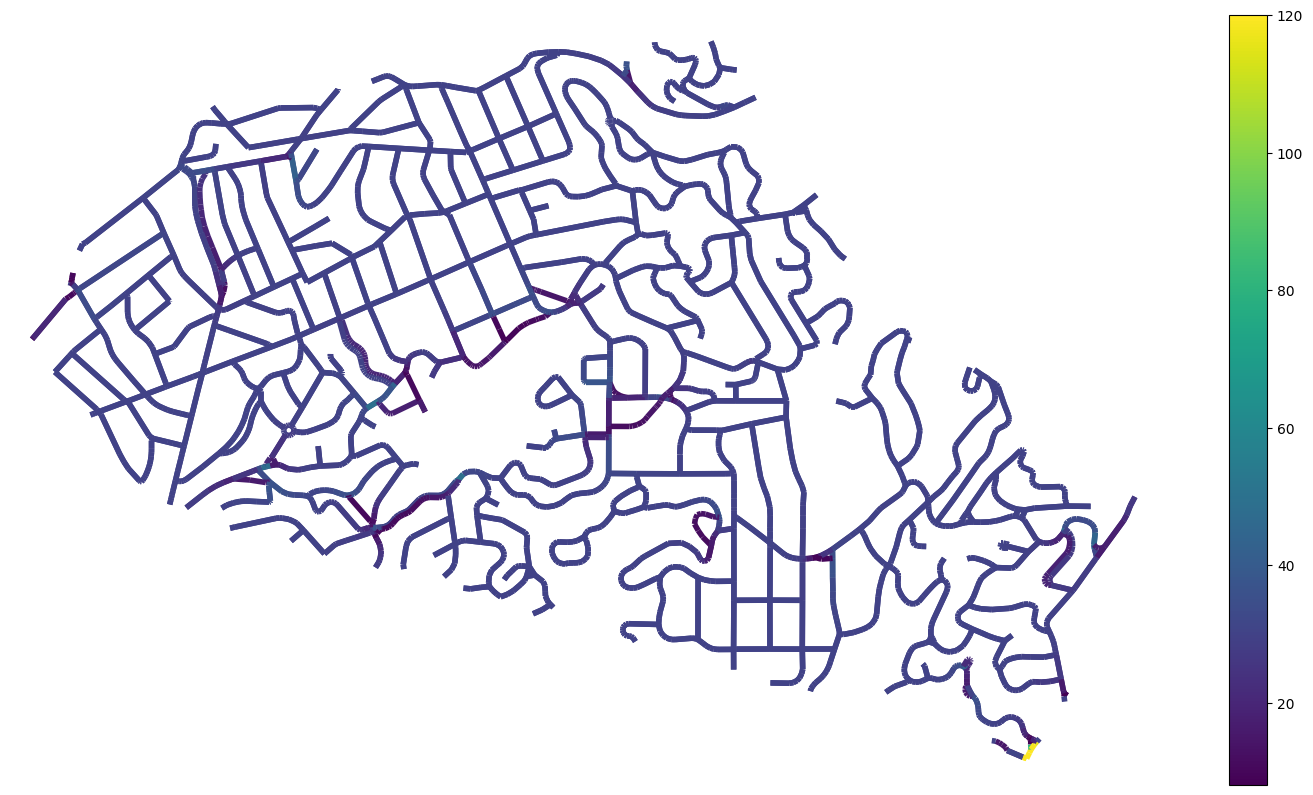

In [15]:
from matplotlib.pyplot import figure

#f, ax = plt.subplots(1, 1, figsize=(20,10))
#f.patch.set_facecolor('black')
fig, ax = plt.subplots(figsize=(30,5))
ax = plot_graph2(rho, ax=ax, title=f'Step {i*200}')
fig.set_size_inches(18.5, 10.)
#f.set_frameon(True)
plt.plot()